In [2]:
import pandas as pd

# Load the dataset
file_path = 'ldt_session_1_data_transformed.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()


,Unnamed: 0,Experiment,v1_mean,v2_mean,zr_mean,a_mean,ndt_mean,sndt_mean,alpha_mean,accuracy_percentage,mean_log_rt,task,session,ID,alpha_mean_arcsin,alpha_mean_boxcox_after_arcsin,accuracy_percentage_arcsin,accuracy_percentage_boxcox_after_arcsin
0,0,3024_class_words_part_1.dat,2.713818,-1.929785,0.516543,1.265116,0.491621,0.018093,1.930676,0.944862,6.604221,LDT,part_1,3024,1.403768,0.557944,1.355729,0.561120
1,12,2005_class_words_part_1.dat,2.294848,-1.882733,0.480014,1.141956,0.515544,0.034769,1.844658,0.924812,6.614017,LDT,part_1,2005,1.301154,0.385059,1.311383,0.465175
2,14,1027_class_words_part_1.dat,3.759410,-4.684975,0.465659,1.512855,0.348644,0.004065,1.624799,0.985000,6.277150,LDT,part_1,1027,1.130450,0.145603,1.500027,0.936727
3,15,1006_class_words_part_1.dat,2.772143,-2.324983,0.575205,0.817880,0.526453,0.050540,1.900512,0.900000,6.495195,LDT,part_1,1006,1.362331,0.485400,1.264599,0.372955
4,20,4004_class_words_part_1.dat,3.273054,-2.231810,0.364242,1.129546,0.405275,0.021561,1.859360,0.955000,6.385288,LDT,part_1,4004,1.315941,0.408585,1.381778,0.621548


In [3]:
import numpy as np
import scipy.stats as stats

# Define the safe Mahalanobis function
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Let's apply this to the first pair of parameters and check the result
pair = ['v1_mean', 'v2_mean']
data_pair = data[pair]

# Calculating Mahalanobis distance for the pair
mahal_distances = safe_mahalanobis(x=data_pair, data=data_pair)

# Determine the p-value threshold for outlier detection (p < 0.001)
p_value_threshold = 0.001

# Calculate the critical value for this p-value under the chi-squared distribution
critical_value = stats.chi2.ppf((1 - p_value_threshold), df=2)

# Identifying outliers
outliers = mahal_distances > critical_value

# Display the first few Mahalanobis distances and the outlier flags
mahal_distances[:5], outliers[:5]


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(array([ 0.10242581,  0.9066783 , 25.87841186,  0.33326377,  0.69555688]),
 array([False, False,  True, False, False]))

In [4]:
from itertools import combinations

# Create a list of all parameter combinations
params = ['v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean', 'sndt_mean', 'alpha_mean', 
          'alpha_mean_boxcox_after_arcsin', 'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin']
param_pairs = list(combinations(params, 2))

# Dictionary to hold the results
outlier_flags = {}

# Apply the outlier detection for each pair
for pair in param_pairs:
    data_pair = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=data_pair, data=data_pair)
    outliers = mahal_distances > critical_value
    outlier_flags[pair] = outliers

# Check the results for a couple of pairs as an example
example_results = {pair: outlier_flags[pair][:5] for pair in param_pairs[:2]}
example_results


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

{('v1_mean', 'v2_mean'): array([False, False,  True, False, False]),
 ('v1_mean', 'zr_mean'): array([False, False, False, False, False])}

In [5]:
# Calculate the correlation coefficients, excluding outliers for each pair
correlation_results = {}

for pair in param_pairs:
    # Filter out the outliers for the pair
    filtered_data = data[list(pair)][~outlier_flags[pair]]
    # Calculate the correlation coefficient
    correlation = filtered_data.corr().iloc[0, 1]
    correlation_results[pair] = correlation

# Check the correlation results for a couple of pairs as an example
example_correlation_results = {pair: correlation_results[pair] for pair in param_pairs[:2]}
example_correlation_results


{('v1_mean', 'v2_mean'): -0.5105784931808836,
 ('v1_mean', 'zr_mean'): -0.3666960594829052}

# Result
{('v1_mean', 'v2_mean'): -0.5105784931808836,
 ('v1_mean', 'zr_mean'): -0.3666960594829052}

NameError: name 'shapiro_results' is not defined

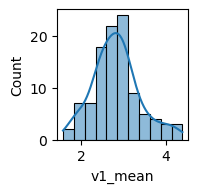

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure for the matrix plot
plt.figure(figsize=(20, 20))

# Number of parameters
num_params = len(params)

# Create the matrix plot
for i in range(num_params):
    for j in range(num_params):
        plt.subplot(num_params, num_params, i * num_params + j + 1)

        # Diagonal: Histograms and Shapiro-Wilk test results
        if i == j:
            sns.histplot(data[params[i]], kde=True)
            plt.title(f'{params[i]}\nShapiro P={shapiro_results[params[i]][1]:.2e}')
        
        # Below Diagonal: Scatter plots
        elif i > j:
            filtered_data = data[list((params[j], params[i]))][~outlier_flags[(params[j], params[i])]]
            sns.scatterplot(data=filtered_data, x=params[j], y=params[i], alpha=0.6)
        
        # Above Diagonal: Correlation values
        else:
            plt.text(0.5, 0.5, f'ρ = {correlation_results[(params[j], params[i])]:.2f}', 
                     ha='center', va='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Correcting the access to correlation results in the matrix plot
plt.figure(figsize=(20, 20))

# Create the matrix plot with the corrected key order for correlation results
for i in range(num_params):
    for j in range(num_params):
        plt.subplot(num_params, num_params, i * num_params + j + 1)

        # Diagonal: Histograms and Shapiro-Wilk test results
        if i == j:
            sns.histplot(data[params[i]], kde=True)
            plt.title(f'{params[i]}\nShapiro P={shapiro_results[params[i]][1]:.2e}')
        
        # Below Diagonal: Scatter plots
        elif i > j:
            filtered_data = data[list((params[j], params[i]))][~outlier_flags[(params[j], params[i])]]
            sns.scatterplot(data=filtered_data, x=params[j], y=params[i], alpha=0.6)
        
        # Above Diagonal: Correlation values
        else:
            # Ensure the correct key order for accessing correlation results
            pair = (params[i], params[j]) if (params[i], params[j]) in correlation_results else (params[j], params[i])
            plt.text(0.5, 0.5, f'ρ = {correlation_results[pair]:.2f}', 
                     ha='center', va='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()


# second analysis 

In [ ]:
import numpy as np
import scipy.stats as stats

def safe_mahalanobis(x=None, data=None, cov=None):
    """ Calculates the Mahalanobis distance for multivariate data. """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# List of parameters to analyze
params = [
    'v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean', 'sndt_mean', 
    'alpha_mean', 'alpha_mean_boxcox_after_arcsin', 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin'
]

# Threshold for p-value
p_value_threshold = 0.001

# Dictionary to store the dataframes after removing outliers for each pair
cleaned_data_pairs = {}

for i in range(len(params)):
    for j in range(i + 1, len(params)):
        # Pair of parameters
        param_x, param_y = params[i], params[j]

        # Subset the data for the two parameters
        data_subset = data[[param_x, param_y]].dropna()

        # Calculate Mahalanobis distance
        mahalanobis_distance = safe_mahalanobis(x=data_subset, data=data_subset)

        # Determine the p-value for each distance
        p_values = 1 - stats.chi2.cdf(mahalanobis_distance, 2)

        # Filter out outliers
        non_outliers = data_subset[p_values > p_value_threshold]

        # Store the cleaned data
        cleaned_data_pairs[(param_x, param_y)] = non_outliers

# Let's print out the number of data points remaining for a few pairs to check
sample_pairs = list(cleaned_data_pairs.keys())[:3]
for pair in sample_pairs:
    print(f"Pair {pair}: Remaining data points = {len(cleaned_data_pairs[pair])}") 

# Confirming the first part is as expected
cleaned_data_pairs[sample_pairs[0]].head()


In [ ]:
# Calculating Pearson correlation for each pair of parameters
correlation_results = {}

for pair, df in cleaned_data_pairs.items():
    correlation = df.corr().iloc[0, 1]
    correlation_results[pair] = correlation

# Displaying the correlation results for the first few pairs as a sample
sample_correlation_results = {pair: correlation_results[pair] for pair in list(correlation_results.keys())[:5]}
sample_correlation_results


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of parameters
num_params = len(params)

# Creating a figure for the matrix plot
plt.figure(figsize=(15, 15))

# Looping over rows and columns for the subplots
for i in range(num_params):
    for j in range(num_params):
        # Create subplot
        ax = plt.subplot(num_params, num_params, i * num_params + j + 1)

        # Diagonal: Histogram and Shapiro test result
        if i == j:
            sns.histplot(data[params[i]].dropna(), ax=ax, kde=True)
            shapiro_stat = shapiro_results[params[i]]['Statistic']
            shapiro_p = shapiro_results[params[i]]['p-value']
            ax.title.set_text(f'{params[i]}\nShapiro p={shapiro_p:.2e}')
        
        # Lower triangle: Scatter plot
        elif i > j:
            sns.scatterplot(x=cleaned_data_pairs[(params[j], params[i])][params[j]], 
                            y=cleaned_data_pairs[(params[j], params[i])][params[i]], ax=ax)
        
        # Upper triangle: Correlation value
        else:
            plt.text(0.5, 0.5, f'r={correlation_results[(params[j], params[i])]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', 
                     transform=ax.transAxes)
            plt.axis('off')

plt.tight_layout()
plt.show()


# third 

In [7]:
import numpy as np
import scipy.stats as stats

# Define the function for Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Select the first pair of parameters to demonstrate the process
params = ['v1_mean', 'v2_mean']
data_subset = data[params]

# Calculate the Mahalanobis distance for each observation
mahal_distances = safe_mahalanobis(x=data_subset, data=data_subset)

# Determine the threshold for outliers using the Chi-square distribution
p_value = 0.001
threshold = stats.chi2.ppf((1 - p_value), df=2)  # df is the number of variables, here 2

# Identify outliers
outliers = mahal_distances > threshold

# Print the number of outliers detected
num_outliers = np.sum(outliers)
num_outliers, threshold


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(1, 13.815510557964274)

In [8]:
import numpy as np
import scipy.stats as stats

# Define the function for Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Select the first pair of parameters to demonstrate the process
params = ['v1_mean', 'v2_mean']
data_subset = data[params]

# Calculate the Mahalanobis distance for each observation
mahal_distances = safe_mahalanobis(x=data_subset, data=data_subset)

# Determine the threshold for outliers using the Chi-square distribution
p_value = 0.001
threshold = stats.chi2.ppf((1 - p_value), df=2)  # df is the number of variables, here 2

# Identify outliers
outliers = mahal_distances > threshold

# Print the number of outliers detected
num_outliers = np.sum(outliers)
num_outliers, threshold


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(1, 13.815510557964274)

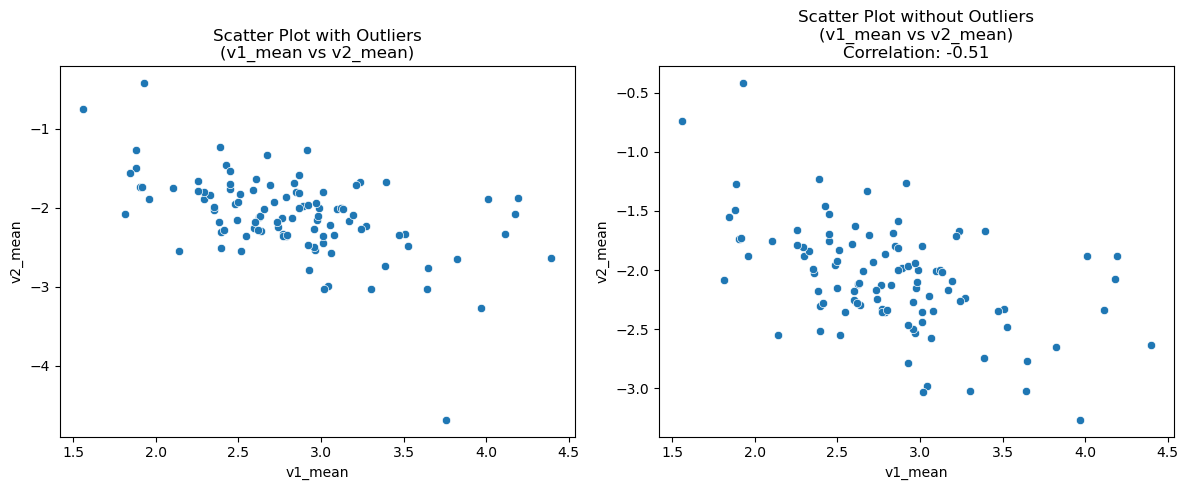

-0.5105784931808836

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove outliers for the first pair
data_no_outliers = data_subset[~outliers]

# Calculate correlation for the first pair without outliers
correlation = data_no_outliers.corr().iloc[0, 1]

# Plotting to show the process
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot with outliers
sns.scatterplot(data=data_subset, x=params[0], y=params[1], ax=ax[0])
ax[0].set_title(f'Scatter Plot with Outliers\n({params[0]} vs {params[1]})')

# Scatter plot without outliers
sns.scatterplot(data=data_no_outliers, x=params[0], y=params[1], ax=ax[1])
ax[1].set_title(f'Scatter Plot without Outliers\n({params[0]} vs {params[1]})\nCorrelation: {correlation:.2f}')

plt.tight_layout()
plt.show()

correlation


In [10]:
from itertools import combinations

# List of all selected parameters
selected_params = ['v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean', 'sndt_mean', 'alpha_mean', 
                   'alpha_mean_boxcox_after_arcsin', 'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin']

# Preparing a DataFrame to store correlations
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)

# Calculate Mahalanobis distance and correlations for each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation  # Mirror the matrix

# Fill diagonal with NaN as we will put histograms there
np.fill_diagonal(correlation_matrix.values, np.nan)

correlation_matrix.head()  # Displaying the first few rows for review


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

,v1_mean,v2_mean,zr_mean,a_mean,ndt_mean,sndt_mean,alpha_mean,alpha_mean_boxcox_after_arcsin,mean_log_rt,accuracy_percentage_boxcox_after_arcsin
v1_mean,NaN,-0.510578,-0.366696,-0.03021,0.012534,-0.307005,0.120436,0.143506,-0.390702,0.538396
v2_mean,-0.510578,NaN,-0.051156,0.048516,0.249568,0.271709,0.12185,0.199351,0.434138,-0.603742
zr_mean,-0.366696,-0.051156,NaN,-0.087975,0.038914,0.256477,0.026213,0.018586,0.039502,-0.211215
a_mean,-0.03021,0.048516,-0.087975,NaN,0.113447,-0.482757,0.537866,0.548133,0.796874,0.71141
ndt_mean,0.012534,0.249568,0.038914,0.113447,NaN,0.16796,0.320045,0.432483,0.627602,-0.133698


In [11]:
# Dictionary to store Shapiro-Wilk test results
shapiro_results = {}

# Perform Shapiro-Wilk test for each parameter
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]  # p-value of the test

shapiro_results


{'v1_mean': 0.03928894177079201,
 'v2_mean': 1.0673813449102454e-05,
 'zr_mean': 0.1917431652545929,
 'a_mean': 0.019229000434279442,
 'ndt_mean': 0.3790469169616699,
 'sndt_mean': 3.5689698307805884e-08,
 'alpha_mean': 1.091578272216509e-09,
 'alpha_mean_boxcox_after_arcsin': 0.7120505571365356,
 'mean_log_rt': 0.2893317937850952,
 'accuracy_percentage_boxcox_after_arcsin': 0.9477624893188477}

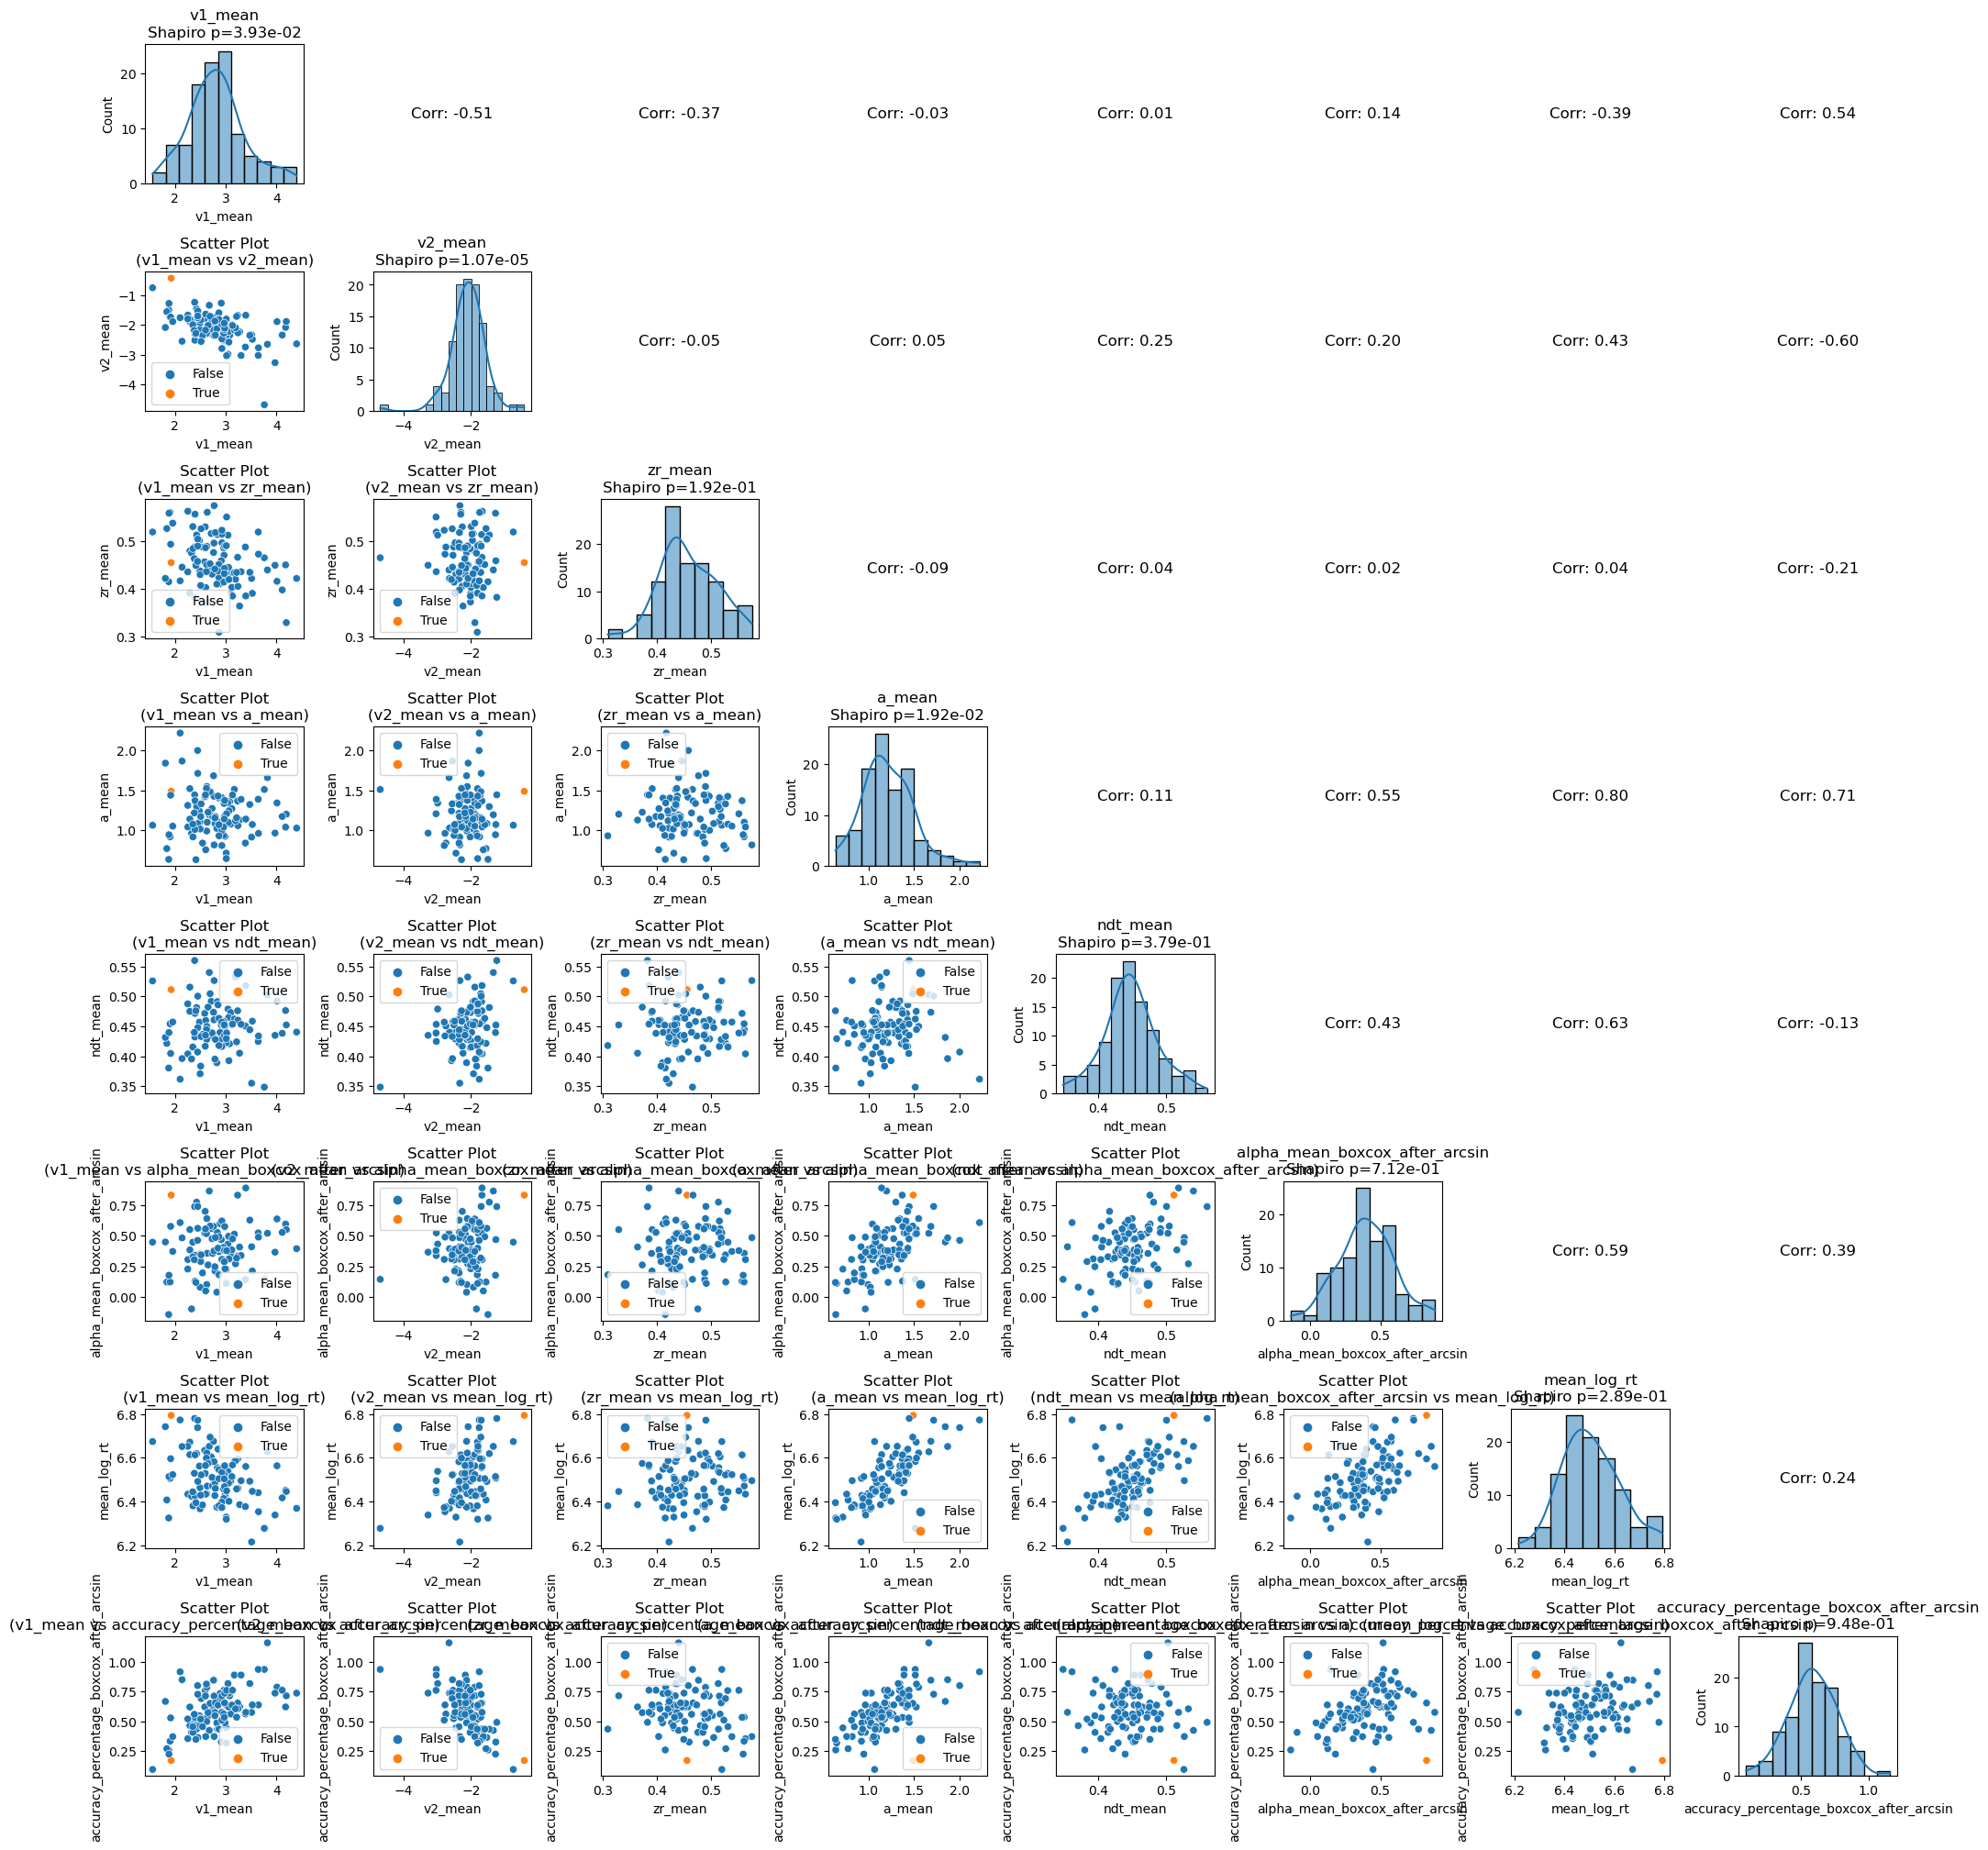

In [25]:
# Create a matrix plot
plt.figure(figsize=(20, 20))

# Loop through rows and columns for plotting
for i in range(len(selected_params)):
    for j in range(len(selected_params)):
        plt.subplot(len(selected_params), len(selected_params), i*len(selected_params) + j + 1)

        # Diagonal: Histograms and Shapiro test results
        if i == j:
            sns.histplot(data[selected_params[i]], kde=True)
            plt.title(f'{selected_params[i]}\nShapiro p={shapiro_results[selected_params[i]]:.2e}')
        
        # Below diagonal: Scatter plots
        elif i > j:
            sns.scatterplot(data=data, x=selected_params[j], y=selected_params[i], hue=outliers, sizes=(2, 200))
            plt.title(f'Scatter Plot\n({selected_params[j]} vs {selected_params[i]})')
        
        # Above diagonal: Correlation values
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', 
                     fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()


KeyError: 'v1'

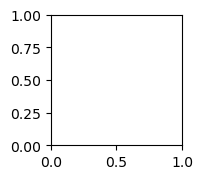

In [14]:
# Update parameter names
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2', 'zr_mean': 'zr', 'a_mean': 'a', 
    'ndt_mean': 'ndt', 'sndt_mean': 'sndt', 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}

# Rename the parameters in the correlation matrix and Shapiro results
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Saving the updated plot to a file
updated_plot_filename = '/mnt/data/correlation_matrix_plot_updated.png'
plt.figure(figsize=(20, 20))

# Re-creating the plot with updated names
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)

        # Diagonal: Histograms and Shapiro test results
        if i == j:
            sns.histplot(data[renamed_params[param_i]], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        
        # Below diagonal: Scatter plots
        elif i > j:
            sns.scatterplot(data=data, x=renamed_params[param_j], y=renamed_params[param_i], hue=outliers)
            plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        
        # Above diagonal: Correlation values
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', 
                     fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.savefig(updated_plot_filename)
plt.close()

updated_plot_filename


In [17]:
# Correcting the renaming process in the dataset
data_renamed = data.rename(columns=renamed_params)

# Re-creating the plot with updated names
updated_plot_filename = 'correlation_matrix_plot_updated.png'
plt.figure(figsize=(20, 20))

for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)

        # Diagonal: Histograms and Shapiro test results
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        
        # Below diagonal: Scatter plots
        elif i > j:
            sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers)
            plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        
        # Above diagonal: Correlation values
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', 
                     fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.savefig(updated_plot_filename)
plt.close()

updated_plot_filename


'correlation_matrix_plot_updated.png'

In [20]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('ldt_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean', 'sndt_mean', 
                   'alpha_mean', 'alpha_mean_boxcox_after_arcsin', 
                   'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2', 'zr_mean': 'zr', 'a_mean': 'a', 
    'ndt_mean': 'ndt', 'sndt_mean': 'sndt', 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
            plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.savefig('correlation_matrix_plot.png')  # Saves the plot to a file
plt.close()



/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

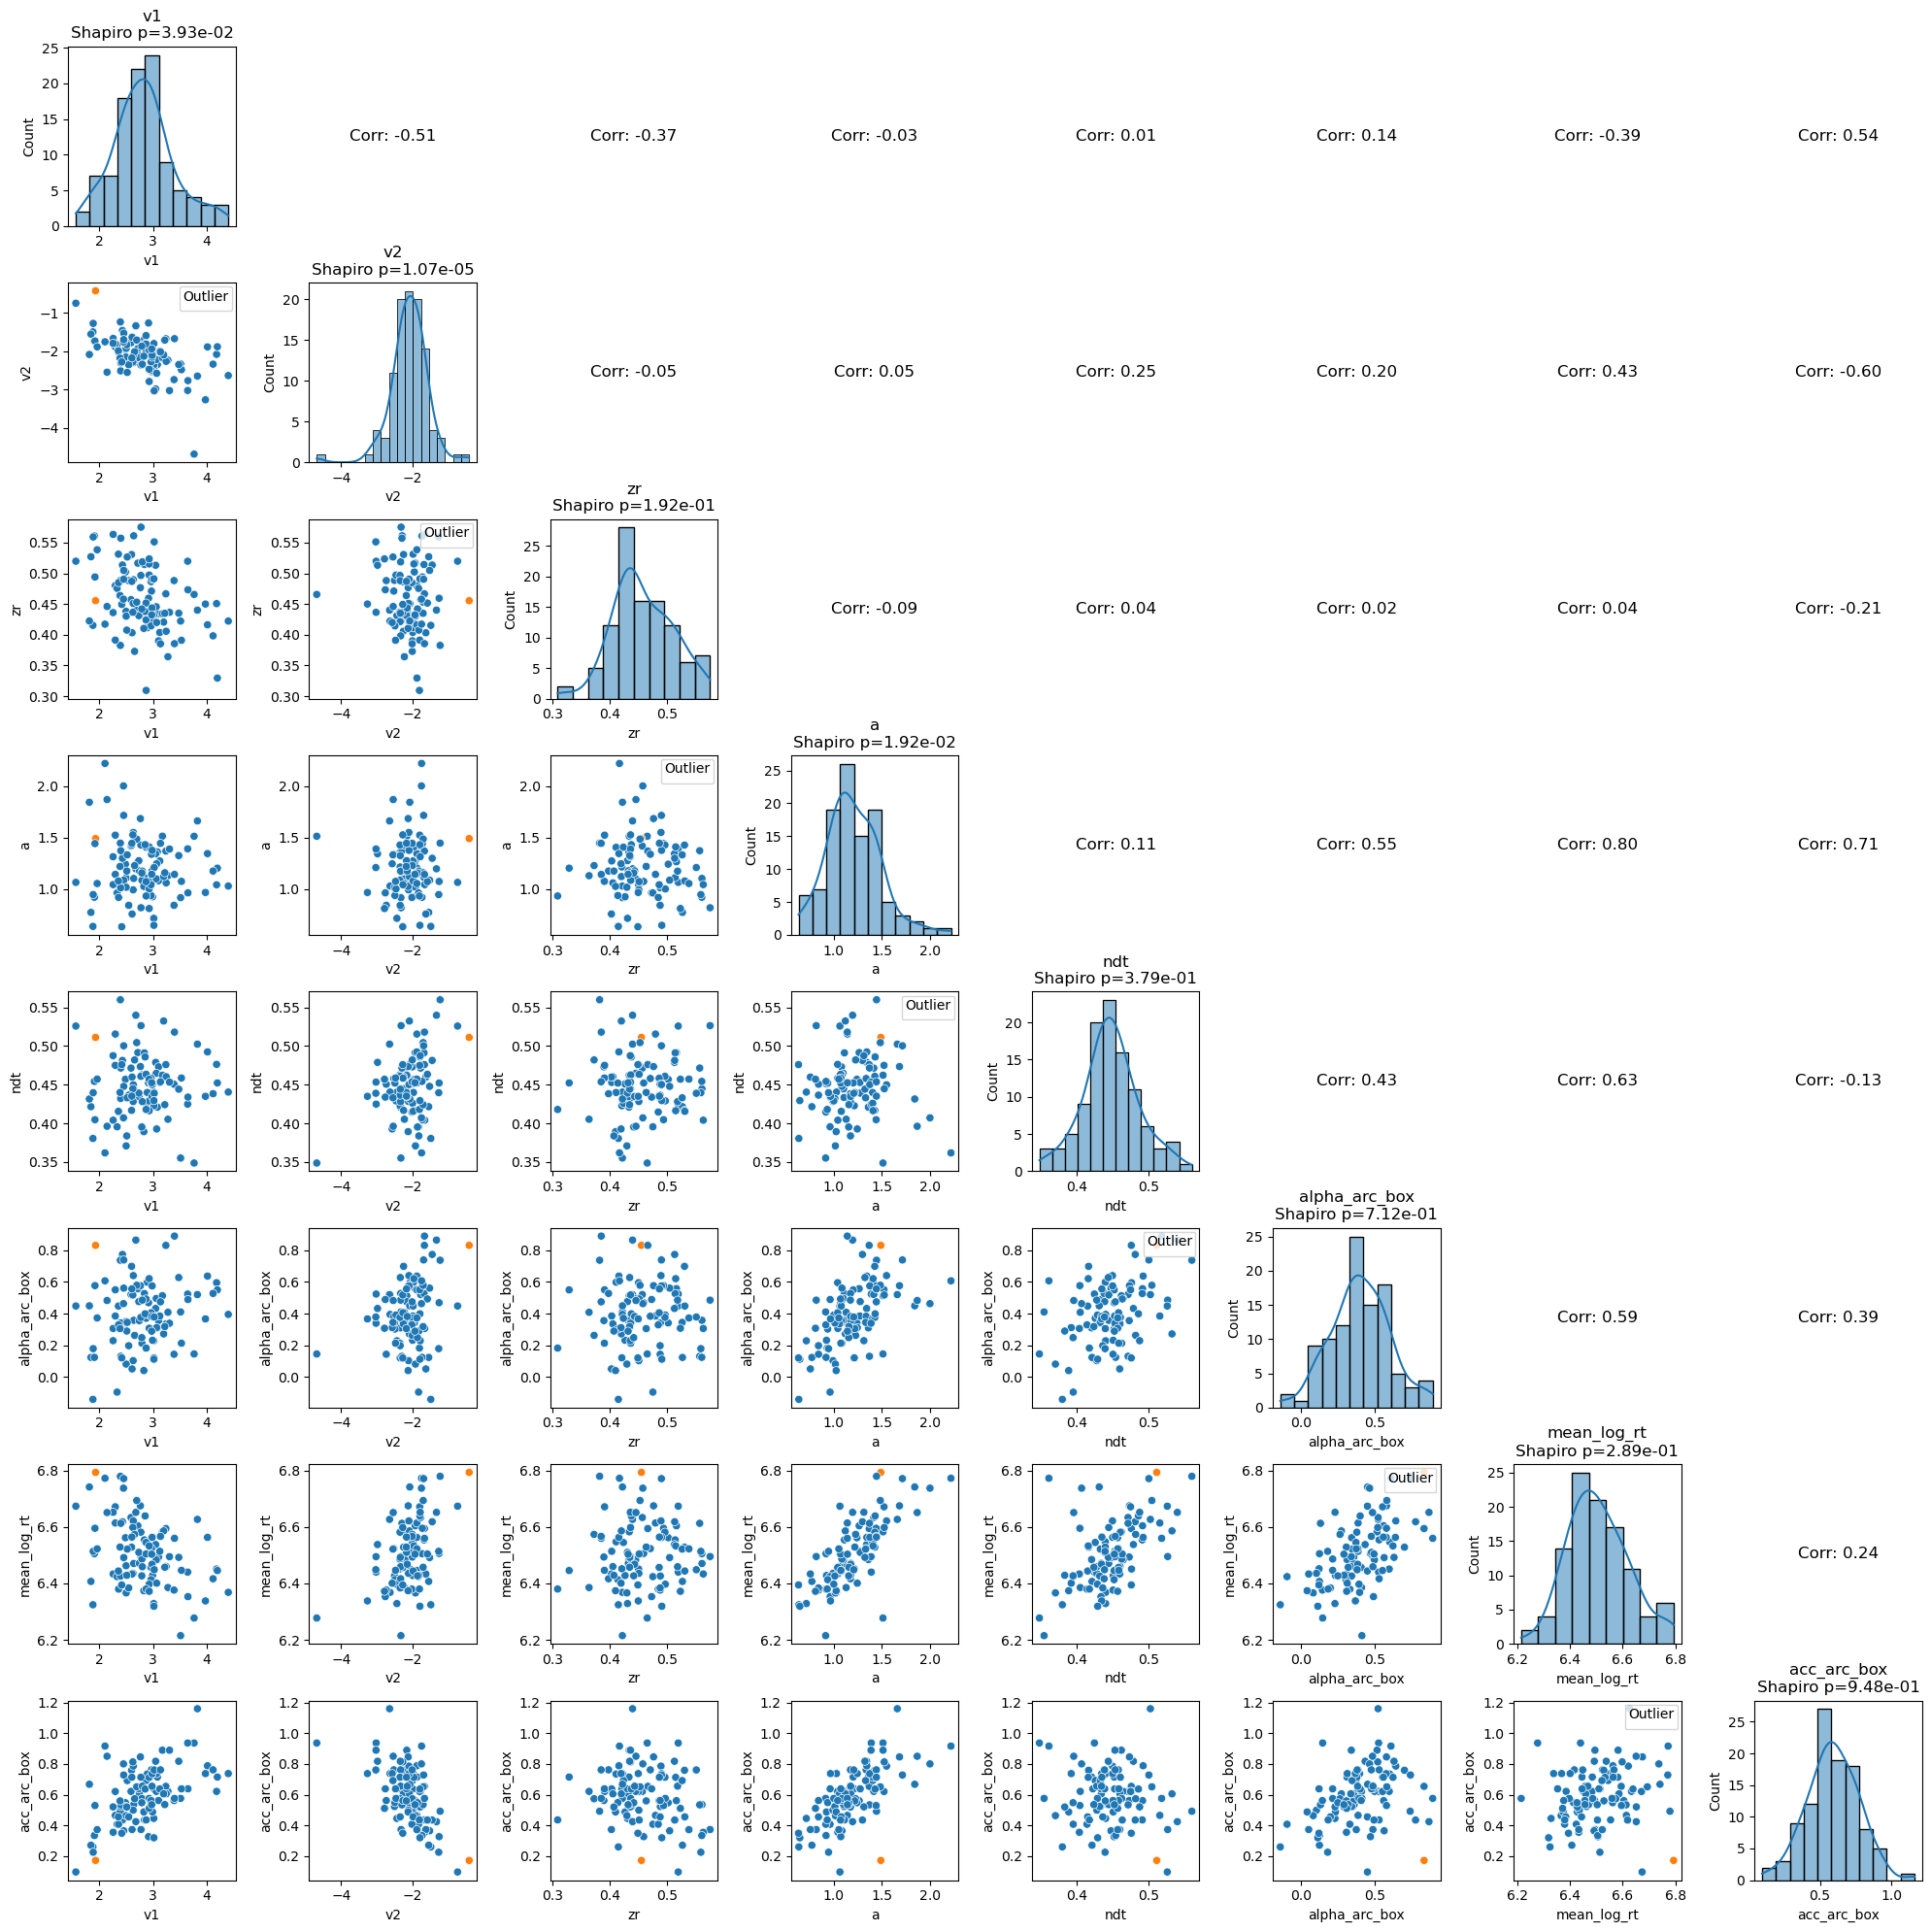

In [23]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('ldt_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean',
                  # 'sndt_mean', 'alpha_mean',
                   'alpha_mean_boxcox_after_arcsin', 
                   'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2', 'zr_mean': 'zr', 'a_mean': 'a', 
    'ndt_mean': 'ndt', #'sndt_mean': 'sndt',# 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
            #plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()

plt.savefig('correlation_matrix_plot.png')  # Saves the plot to a file
plt.close()



In [26]:
correlation_matrix_renamed

,v1,v2,zr,a,ndt,alpha_arc_box,mean_log_rt,acc_arc_box
v1,NaN,-0.510578,-0.366696,-0.03021,0.012534,0.143506,-0.390702,0.538396
v2,-0.510578,NaN,-0.051156,0.048516,0.249568,0.199351,0.434138,-0.603742
zr,-0.366696,-0.051156,NaN,-0.087975,0.038914,0.018586,0.039502,-0.211215
a,-0.03021,0.048516,-0.087975,NaN,0.113447,0.548133,0.796874,0.71141
ndt,0.012534,0.249568,0.038914,0.113447,NaN,0.432483,0.627602,-0.133698
alpha_arc_box,0.143506,0.199351,0.018586,0.548133,0.432483,NaN,0.587427,0.389036
mean_log_rt,-0.390702,0.434138,0.039502,0.796874,0.627602,0.587427,NaN,0.243175
acc_arc_box,0.538396,-0.603742,-0.211215,0.71141,-0.133698,0.389036,0.243175,NaN
